In [1]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy import stats

from imblearn.over_sampling import SMOTE

In [2]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
file = tf.keras.utils
df1 = pd.read_csv('../data/2020/20_agg_data.csv')
df2 = pd.read_csv('../data/2019/19_agg_data.csv')
df3 = pd.read_csv('../data/2018/18_agg_data.csv')
df_list = [df1, df2, df3]

In [4]:
comb_df = pd.concat(df_list)
comb_df.describe()

,Time,Max Concentration,Last Pit,Air Temp,Track Temp,Humidity,Pressure,Wind Speed,Yellow
count,11813.000000,11813.000000,11813.000000,11813.000000,11813.000000,11813.000000,11813.000000,11813.000000,11813.000000
mean,40604.892915,6.700618,50.999474,60.767723,61.705157,68.283840,30.133232,2.138085,0.007788
std,24159.313746,3.021356,16.870688,7.824666,9.638736,14.604254,0.070174,2.085328,0.087909
min,20.000000,0.533049,0.333333,46.400000,32.000000,34.000000,29.976005,0.000000,0.000000
25%,19720.000000,4.567957,42.882450,54.800060,55.000040,59.000000,30.080246,0.600000,0.000000
50%,40080.000000,6.048387,50.174283,60.499940,62.000060,69.000000,30.123064,1.300000,0.000000
75%,59800.000000,8.333333,54.630800,66.700040,64.999940,81.000000,30.177990,3.200000,0.000000
max,86440.000000,33.333333,144.666667,77.000000,98.000060,92.000000,30.269238,15.100000,1.000000


In [5]:
neg, pos = np.bincount(comb_df['Yellow'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 11813
    Positive: 92 (0.78% of total)



In [6]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

def make_model(metrics=METRICS, output_bias=None, dropout=0.5, input_shape=(7,)):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=input_shape),
      keras.layers.Dropout(dropout),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
    ])

    model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

    return model

In [7]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [8]:
initial_bias = np.log([pos/neg])

In [9]:
model = make_model(output_bias=initial_bias)

In [10]:
initial_weights = '../data/inital_weights'
model.save_weights(initial_weights)

In [11]:
def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')

In [12]:
def plot_metrics(history):
    metrics = ['loss', 'auc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.4,.8])
        else:
            plt.ylim([-0.1,1])

        plt.legend()

In [13]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Green Flags Predicted (True Negatives): ', cm[0][0])
    print('Yellow Flags Incorrectly Predicted (False Positives): ', cm[0][1])
    print('Yellow Flags Missed (False Negatives): ', cm[1][0])
    print('Yellow Flags Correctly Predicted (True Positives): ', cm[1][1])
    print('Total Yellow Flags: ', np.sum(cm[1]))

In [14]:
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.xlim([-0.5,100])
    plt.ylim([0,100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

In [15]:
BUFFER_SIZE = 100000

def make_ds(features, labels):
    ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
    ds = ds.shuffle(BUFFER_SIZE).repeat()
    return ds

Testing on df 1
loss :  0.10869539529085159
tp :  0.0
fp :  1.0
tn :  4288.0
fn :  24.0
accuracy :  0.9942035675048828
precision :  0.0
recall :  0.0
auc :  0.5042453408241272



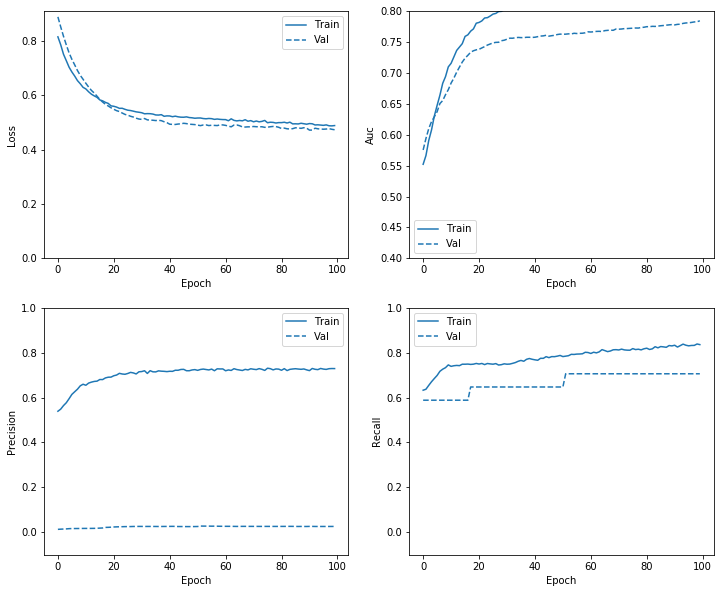

Green Flags Predicted (True Negatives):  4288
Yellow Flags Incorrectly Predicted (False Positives):  1
Yellow Flags Missed (False Negatives):  24
Yellow Flags Correctly Predicted (True Positives):  0
Total Yellow Flags:  24


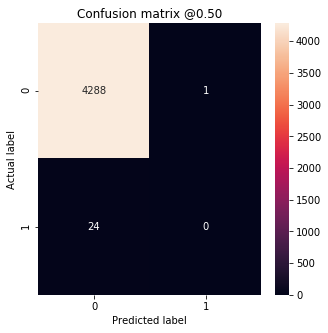

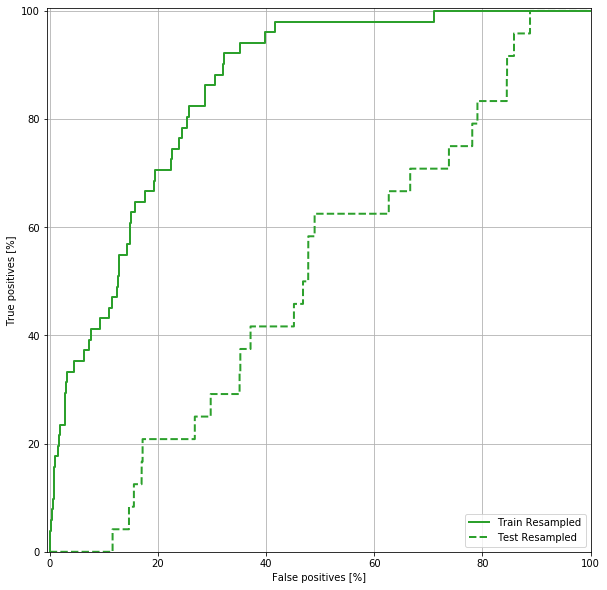

Testing on df 2


KeyboardInterrupt: 

In [16]:
for i in range(0, 3):
    df1 = pd.read_csv('../data/2020/20_agg_data.csv')
    df2 = pd.read_csv('../data/2019/19_agg_data.csv')
    df3 = pd.read_csv('../data/2018/18_agg_data.csv')
    df_list = [df1, df2, df3]
    
    print('Testing on df', str(i+1))
    test_df = df_list[i]
    test_df.pop('Time')
#     print(test_df.head)
    
    train_list = df_list[:i] + df_list[i+1:]
    train_df = pd.concat(train_list) 
    train_df.pop('Time')
#     print(train_df.head)

    eps = 0.001 
    train_df['Last Pit'] = np.log(train_df['Last Pit']+eps)
    train_df, val_df = train_test_split(train_df, test_size=0.2)
    
    # Form np arrays of labels and features.
    train_labels = np.array(train_df.pop('Yellow'))
    bool_train_labels = train_labels != 0
    val_labels = np.array(val_df.pop('Yellow'))
    test_labels = np.array(test_df.pop('Yellow'))

    train_features = np.array(train_df)
    val_features = np.array(val_df)
    test_features = np.array(test_df)
    
    # Standard Scale and clip
    scaler = StandardScaler()
    train_features = scaler.fit_transform(train_features)

    val_features = scaler.transform(val_features)
    test_features = scaler.transform(test_features)

    train_features = np.clip(train_features, -5, 5)
    val_features = np.clip(val_features, -5, 5)
    test_features = np.clip(test_features, -5, 5)
    
    # Resampling 
    pos_features = train_features[bool_train_labels]
    neg_features = train_features[~bool_train_labels]
    pos_labels = train_labels[bool_train_labels]
    neg_labels = train_labels[~bool_train_labels]
    
    pos_ds = make_ds(pos_features, pos_labels)
    neg_ds = make_ds(neg_features, neg_labels)
    
    resampled_ds = tf.data.experimental.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
    resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)
    resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)
    
    # Run model
    resampled_model = make_model(dropout=0.38, input_shape=(train_features.shape[-1],))
    resampled_model.load_weights(initial_weights)

    # Reset the bias to zero, since this dataset is balanced.
    output_layer = resampled_model.layers[-1] 
    output_layer.bias.assign([0])

    val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).cache()
    val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

    resampled_history = resampled_model.fit(
        resampled_ds,
        epochs=EPOCHS,
        steps_per_epoch=resampled_steps_per_epoch,
        callbacks=[early_stopping],
        validation_data=val_ds,
        verbose=0
    )
    
    # plots
    plot_metrics(resampled_history)
    train_predictions_resampled = resampled_model.predict(train_features, batch_size=BATCH_SIZE)
    test_predictions_resampled = resampled_model.predict(test_features, batch_size=BATCH_SIZE)
    
    resampled_results = resampled_model.evaluate(test_features, test_labels,
                                             batch_size=BATCH_SIZE, verbose=0)
    for name, value in zip(resampled_model.metrics_names, resampled_results):
        print(name, ': ', value)
    print()
    plt.show()

    plot_cm(test_labels, test_predictions_resampled)
    plt.show()

    plot_roc("Train Resampled", train_labels, train_predictions_resampled, color=colors[2])
    plot_roc("Test Resampled", test_labels, test_predictions_resampled, color=colors[2], linestyle='--')
    plt.legend(loc='lower right')
    plt.show()